In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [31]:
data_dir_original = r"D:\MED_LEAF_ID\data\cnn\original"
data_dir_augmented = r"D:\MED_LEAF_ID\data\cnn\augmented"
save_model_path = r"D:\MED_LEAF_ID\models\\cnn.h5"


In [4]:
IMG_SIZE = (224, 224)  # Input size for EfficientNet
BATCH_SIZE = 32
EPOCHS = 50
VALIDATION_SPLIT = 0.15  # 15% for validation
TEST_SPLIT = 0.15  # 15% for testing

In [5]:
def prepare_datasets(original_dir, augmented_dir):
    # Load datasets
    original_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        original_dir,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )
    augmented_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        augmented_dir,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE
    )

    # Extract class names (assuming both have the same classes)
    class_names = original_dataset.class_names

    # Combine datasets
    dataset = original_dataset.concatenate(augmented_dataset)

    # Calculate split sizes
    total_size = len(dataset)
    val_size = int(VALIDATION_SPLIT * total_size)
    test_size = int(TEST_SPLIT * total_size)
    train_size = total_size - val_size - test_size

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_test_dataset = dataset.skip(train_size)
    val_dataset = val_test_dataset.take(val_size)
    test_dataset = val_test_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset, class_names

In [6]:
train_dataset, val_dataset, test_dataset, class_names = prepare_datasets(data_dir_original, data_dir_augmented)



Found 12812 files belonging to 90 classes.
Found 5805 files belonging to 10 classes.


In [7]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [8]:
preprocess_input = applications.efficientnet.preprocess_input

In [9]:
base_model = applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), weights="imagenet")
base_model.trainable = False  # Freeze base model


In [11]:
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)  # Regularization
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = models.Model(inputs, outputs)


In [12]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 206s 483ms/step - accuracy: 0.2823 - loss: 3.2409 - val_accuracy: 0.1394 - val_loss: 3.8737
Epoch 2/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 236s 577ms/step - accuracy: 0.6513 - loss: 1.4725 - val_accuracy: 0.3333 - val_loss: 2.5155
Epoch 3/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 252s 617ms/step - accuracy: 0.7412 - loss: 1.0896 - val_accuracy: 0.4249 - val_loss: 2.0485
Epoch 4/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 272s 664ms/step - accuracy: 0.7895 - loss: 0.8717 - val_accuracy: 0.4838 - val_loss: 1.8021
Epoch 5/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 261s 638ms/step - accuracy: 0.8146 - loss: 0.7531 - val_accuracy: 0.5550 - val_loss: 1.5519
Epoch 6/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 267s 653ms/step - accuracy: 0.8355 - loss: 0.6679 - val_accuracy: 0.5851 - val_loss: 1.4762
Epoch 7/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 263s 644ms/step - accuracy: 0.8481 - loss: 0.6084 - val_accuracy: 0.6110 - val_loss: 1.3624
Epoch 8/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 259s 633ms/step - accuracy: 0.8565 -

In [14]:
eval_results = model.evaluate(test_dataset)
print(f"\nTest Loss: {eval_results[0]}\nTest Accuracy: {eval_results[1]}")


87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 403ms/step - accuracy: 0.7649 - loss: 0.7847

Test Loss: 0.7587890028953552
Test Accuracy: 0.7768535017967224


In [15]:
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=-1)


87/87 ━━━━━━━━━━━━━━━━━━━━ 41s 408ms/step


In [21]:
unique_classes = np.unique(y_true)
print(f"Unique classes in test set: {len(unique_classes)}")
print(f"Class labels in test set: {unique_classes}")

unique_class_names = [class_names[i] for i in unique_classes]
print("Classification Report:\n", classification_report(y_true, y_pred, labels=unique_classes, target_names=unique_class_names))



Unique classes in test set: 10
Class labels in test set: [0 1 2 3 4 5 6 7 8 9]
Classification Report:
               precision    recall  f1-score   support

    Aloevera       0.12      0.09      0.10       274
        Amla       0.11      0.10      0.11       259
Amruthaballi       0.11      0.11      0.11       270
       Arali       0.06      0.06      0.06       222
 Ashwagandha       0.29      0.26      0.27       685
  Astma_weed       0.09      0.06      0.08       231
     Avacado       0.06      0.07      0.06       214
    Badipala       0.06      0.06      0.06       201
Balloon_Vine       0.10      0.08      0.09       228
      Bamboo       0.09      0.07      0.08       181

   micro avg       0.14      0.12      0.13      2765
   macro avg       0.11      0.10      0.10      2765
weighted avg       0.14      0.12      0.13      2765



In [23]:

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[24 28 24 ...  1  2  0]
 [29 27 22 ...  0  1  0]
 [21 29 29 ...  0  1  1]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


In [29]:
model.save(save_model_path)
print(f"Model saved to {save_model_path}")


Model saved to D:\MED_LEAF_ID\models\\cnn.h5


In [17]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


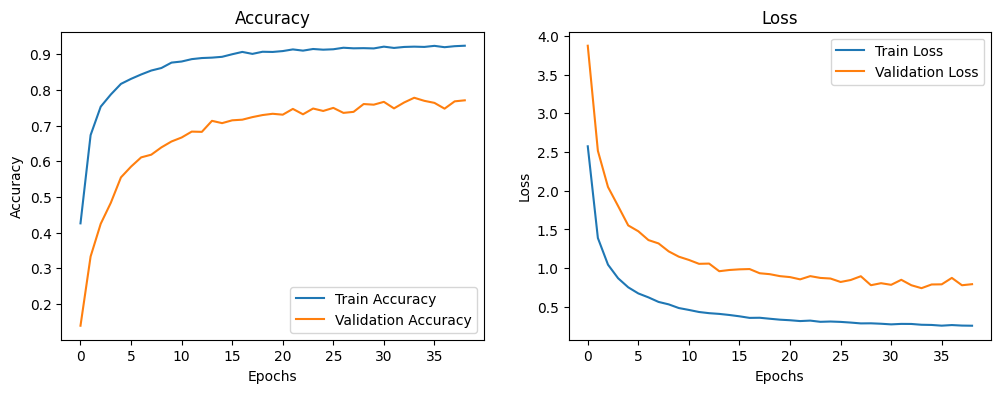

In [18]:
plot_training_history(history)

NameError: name 'train_labels' is not defined